## Extra EfficientNet Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize


In [2]:
def trainingModel(model, tr_loader, va_loader,learning_rate, num_epoch=10):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    # Optimizer and Loss Function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # History
    history = {"train_loss": [], "valid_loss": [], "valid_accuracy": []}

    # Track the best model
    best_valid_loss = float('inf')  # Initialize to infinity
    best_model_wts = None

    # Training and Validation Loop with Progress Updates
    epochs = num_epoch
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training Phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        # Use tqdm for batch-level progress
        for images, labels in tqdm(tr_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(tr_loader)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=1)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=1)
        
        # Validation Phase
        model.eval()
        valid_loss = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            # Use tqdm for validation progress
            for images, labels in tqdm(va_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        valid_loss /= len(va_loader)
        valid_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        valid_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)

        epoch_duration = time.time() - start_time

        # Store in history
        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["valid_accuracy"].append(valid_accuracy)

        # Print the progress with more metrics and time per epoch
        print(f"Epoch {epoch+1}/{epochs} - Duration: {epoch_duration:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid F1 Score: {valid_f1:.4f}, Valid Precision: {valid_precision:.4f}, Valid Recall: {valid_recall:.4f}")

        # Save the best model weights
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_wts = model.state_dict()

    return model, history, best_model_wts

### Define training Dataloader

In [3]:
def loadTrainingData(i_size, b_size, original=True):
    # Data transformations with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    valid_test_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Datasets
    train_dataset = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=train_transforms)
    valid_dataset = datasets.ImageFolder("butterfly_and_moth_classification/valid", transform=valid_test_transforms)
    test_dataset = datasets.ImageFolder("butterfly_and_moth_classification/test", transform=valid_test_transforms)

    # DataLoaders
    batch_size = b_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if(original == False):
        train_original = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=valid_test_transforms) # original training set
        augmented_dataset = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=train_transforms) # trainsformed training set
        train_combined = ConcatDataset([train_original, augmented_dataset])
        train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Validation set size: {len(valid_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [4]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set CUDA seed (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # for all GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input size 128 x 128, batch_size = 64, learning rate = 0.0001, original training set, num_epoch = 20

In [6]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(128,64);
num_classes = len(train_dataset.classes)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model_efficientnet, history_effiNet, best_wts_effiNet = trainingModel(model, train_loader, valid_loader, learning_rate=0.0001, num_epoch=20)

Training set size: 12594
Validation set size: 500
Test set size: 500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Duration: 126.56s
Train Loss: 3.4628, Train Precision: 0.3972, Train Recall: 0.3745
Valid Loss: 1.6896, Valid Accuracy: 0.7720, Valid F1 Score: 0.7493, Valid Precision: 0.8338, Valid Recall: 0.7720


Epoch 2/20 - Duration: 124.95s
Train Loss: 1.1280, Train Precision: 0.8099, Train Recall: 0.8010
Valid Loss: 0.5633, Valid Accuracy: 0.8880, Valid F1 Score: 0.8825, Valid Precision: 0.9105, Valid Recall: 0.8880


Epoch 3/20 - Duration: 126.23s
Train Loss: 0.5346, Train Precision: 0.8811, Train Recall: 0.8797
Valid Loss: 0.3343, Valid Accuracy: 0.9240, Valid F1 Score: 0.9219, Valid Precision: 0.9342, Valid Recall: 0.9240


Epoch 4/20 - Duration: 125.61s
Train Loss: 0.3698, Train Precision: 0.9110, Train Recall: 0.9096
Valid Loss: 0.2536, Valid Accuracy: 0.9320, Valid F1 Score: 0.9299, Valid Precision: 0.9401, Valid Recall: 0.9320


Epoch 5/20 - Duration: 125.13s
Train Loss: 0.2761, Train Precision: 0.9311, Train Recall: 0.9308
Valid Loss: 0.2169, Valid Accuracy: 0.9440, Valid F1 Score: 0.9431, Valid Precision: 0.9508, Valid Recall: 0.9440


Epoch 6/20 - Duration: 125.47s
Train Loss: 0.2162, Train Precision: 0.9443, Train Recall: 0.9438
Valid Loss: 0.1928, Valid Accuracy: 0.9520, Valid F1 Score: 0.9519, Valid Precision: 0.9588, Valid Recall: 0.9520


Epoch 7/20 - Duration: 128.03s
Train Loss: 0.1810, Train Precision: 0.9520, Train Recall: 0.9513
Valid Loss: 0.1838, Valid Accuracy: 0.9460, Valid F1 Score: 0.9450, Valid Precision: 0.9535, Valid Recall: 0.9460


Epoch 8/20 - Duration: 120.04s
Train Loss: 0.1528, Train Precision: 0.9581, Train Recall: 0.9581
Valid Loss: 0.1791, Valid Accuracy: 0.9500, Valid F1 Score: 0.9493, Valid Precision: 0.9573, Valid Recall: 0.9500


Epoch 9/20 - Duration: 123.31s
Train Loss: 0.1306, Train Precision: 0.9652, Train Recall: 0.9650
Valid Loss: 0.1770, Valid Accuracy: 0.9580, Valid F1 Score: 0.9574, Valid Precision: 0.9633, Valid Recall: 0.9580


Epoch 10/20 - Duration: 135.16s
Train Loss: 0.1094, Train Precision: 0.9695, Train Recall: 0.9695
Valid Loss: 0.1725, Valid Accuracy: 0.9540, Valid F1 Score: 0.9537, Valid Precision: 0.9608, Valid Recall: 0.9540


Epoch 11/20 - Duration: 127.35s
Train Loss: 0.0932, Train Precision: 0.9760, Train Recall: 0.9758
Valid Loss: 0.1695, Valid Accuracy: 0.9560, Valid F1 Score: 0.9553, Valid Precision: 0.9621, Valid Recall: 0.9560


Epoch 12/20 - Duration: 125.47s
Train Loss: 0.0851, Train Precision: 0.9762, Train Recall: 0.9761
Valid Loss: 0.1770, Valid Accuracy: 0.9600, Valid F1 Score: 0.9595, Valid Precision: 0.9653, Valid Recall: 0.9600


Epoch 13/20 - Duration: 125.28s
Train Loss: 0.0696, Train Precision: 0.9806, Train Recall: 0.9803
Valid Loss: 0.1903, Valid Accuracy: 0.9540, Valid F1 Score: 0.9536, Valid Precision: 0.9608, Valid Recall: 0.9540


Epoch 14/20 - Duration: 126.42s
Train Loss: 0.0631, Train Precision: 0.9829, Train Recall: 0.9828
Valid Loss: 0.1822, Valid Accuracy: 0.9600, Valid F1 Score: 0.9597, Valid Precision: 0.9660, Valid Recall: 0.9600


Epoch 15/20 - Duration: 129.31s
Train Loss: 0.0566, Train Precision: 0.9850, Train Recall: 0.9849
Valid Loss: 0.1869, Valid Accuracy: 0.9500, Valid F1 Score: 0.9498, Valid Precision: 0.9568, Valid Recall: 0.9500


Epoch 16/20 - Duration: 132.31s
Train Loss: 0.0498, Train Precision: 0.9863, Train Recall: 0.9863
Valid Loss: 0.1959, Valid Accuracy: 0.9560, Valid F1 Score: 0.9555, Valid Precision: 0.9613, Valid Recall: 0.9560


Epoch 17/20 - Duration: 135.32s
Train Loss: 0.0442, Train Precision: 0.9882, Train Recall: 0.9879
Valid Loss: 0.2047, Valid Accuracy: 0.9560, Valid F1 Score: 0.9546, Valid Precision: 0.9616, Valid Recall: 0.9560


Epoch 18/20 - Duration: 136.03s
Train Loss: 0.0418, Train Precision: 0.9888, Train Recall: 0.9889
Valid Loss: 0.1894, Valid Accuracy: 0.9580, Valid F1 Score: 0.9574, Valid Precision: 0.9653, Valid Recall: 0.9580


Epoch 19/20 - Duration: 136.74s
Train Loss: 0.0388, Train Precision: 0.9896, Train Recall: 0.9895
Valid Loss: 0.2110, Valid Accuracy: 0.9580, Valid F1 Score: 0.9574, Valid Precision: 0.9645, Valid Recall: 0.9580


Epoch 20/20 - Duration: 133.88s
Train Loss: 0.0358, Train Precision: 0.9900, Train Recall: 0.9899
Valid Loss: 0.2227, Valid Accuracy: 0.9540, Valid F1 Score: 0.9535, Valid Precision: 0.9608, Valid Recall: 0.9540


Evaluation

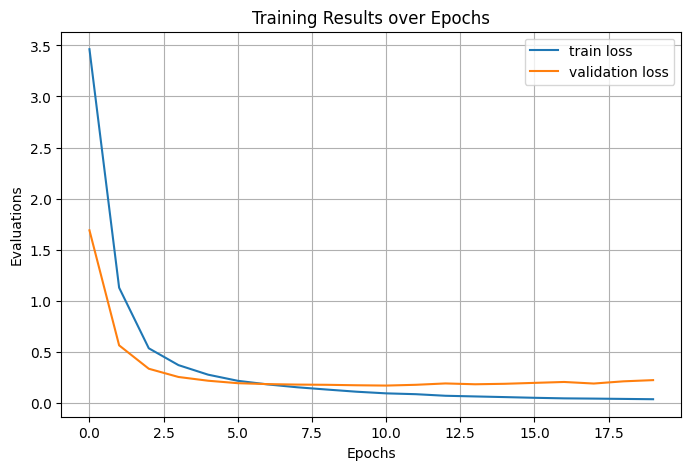

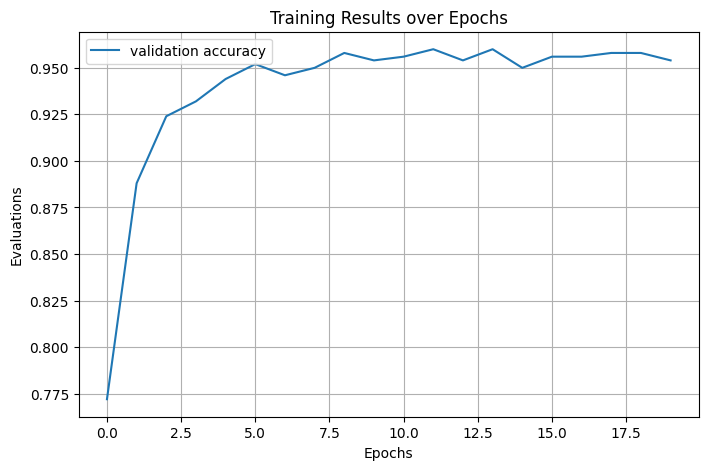

In [9]:
# Plot Training and Valid Loss
plt.figure(figsize=(8, 5))
plt.plot(history_effiNet["train_loss"], label="train loss")
plt.plot(history_effiNet["valid_loss"], label="validation loss")
plt.title("Training Results over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Evaluations")
plt.legend()
plt.grid(True)
plt.show()


# Plot Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_effiNet["valid_accuracy"], label="validation accuracy")
plt.title("Training Results over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Evaluations")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model_efficientnet.load_state_dict(best_wts_effiNet)
model_efficientnet.to(device)
model_efficientnet.eval()
all_labels = []
all_preds = []
all_probs = []

# Perform on test set
test_loss = 0.0
with torch.no_grad():
    # Use tqdm for validation progress
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precison: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Test Loss: 0.1115
Test Accuracy: 0.9680
Test F1 Score: 0.9677
Test Precison: 0.9735
Test Recall: 0.9680
